In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import os.path as op
from countryinfo import CountryInfo
from tqdm.notebook import tqdm
import re
import time
import gc


import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, html, dcc, callback, Output, Input

sys.path.insert(0, '..') # project folder

from config import *
from country_analysis import get_iso3, get_country_fullname
path_country_fig = op.join('..','data', 'figures','countries')

In [2]:
edu = pd.DataFrame()
for i in range(N_BATCHES):
    batch = pd.read_csv(path_edu.format(i), index_col=0).drop(columns = ['description', 'crawl_date', 'title', 'tags'])
    edu = pd.concat([edu, batch])
    del batch

edu = edu.rename(columns={'channel_id': 'channel', 'categories': 'vid_category'})

In [3]:
countries = pd.read_csv(op.join(path_deriv, 'countries.csv'), index_col=0, dtype={'country': str, 'channel_id': str}).rename(columns={'channel_id': 'channel'})
classif = pd.read_csv(path_classified)[['display_id', 'category']]

channels = pd.read_csv(path_channels, compression="infer", sep="\t")#.drop ... # TODO
channels = channels[['channel', 'join_date', 'name_cc', 'subscribers_cc', 'videos_cc', 'subscriber_rank_sb']]
edu = edu.merge(channels, on='channel', how='left')
edu = edu.merge(classif, on='display_id', how='left')
edu = edu.merge(countries, on='channel', how='left')
edu.head()

,vid_category,channel,dislike_count,display_id,duration,like_count,upload_date,view_count,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,category,country
0,Education,UCzWrhkg9eK5I8Bm3HfV-unA,3.0,jCaqrZ8gSkY,116,11.0,2016-05-03 00:00:00,2720.0,2013-08-26,Supertronic,314000,2398,54617.0,5,US
1,Education,UCzWrhkg9eK5I8Bm3HfV-unA,1094.0,VZ6_wQxKVSI,940,2884.0,2015-06-30 00:00:00,4530589.0,2013-08-26,Supertronic,314000,2398,54617.0,unclass,US
2,Education,UCzWrhkg9eK5I8Bm3HfV-unA,4.0,0CsvKzQNd7g,412,12.0,2015-06-20 00:00:00,18053.0,2013-08-26,Supertronic,314000,2398,54617.0,5,US
3,Education,UCzWn_gTaXyH5Idyo8Raf7_A,2.0,WNR69JYddKA,156,68.0,2015-07-24 00:00:00,7758.0,2013-11-28,Catfish and Carp,621000,489,27674.0,unclass,US
4,Education,UCzWn_gTaXyH5Idyo8Raf7_A,8.0,0alQMm9IOaI,1109,124.0,2015-07-17 00:00:00,7499.0,2013-11-28,Catfish and Carp,621000,489,27674.0,unclass,US


# Data cleaning

In [4]:
edu = edu[~edu.country.isin(['no_rec', 'deleted', 'no_country'])]

# plot Channels per country

In [5]:
ch_per_country = edu.groupby(['country', 'channel']).count().reset_index().groupby('country').count().reset_index()[['country', 'channel']].rename(columns={'channel': '# channels'}).sort_values(by='# channels', ascending=False)
ch_per_country['country_iso3'] = ch_per_country.country.apply(get_iso3)
ch_per_country['country_name'] = ch_per_country.country.apply(get_country_fullname)
ch_per_country.to_csv(op.join(path_deriv, 'channels_per_country.csv'))
ch_per_country

,country,# channels,country_iso3,country_name
116,US,12312,USA,United States
54,IN,2464,IND,India
42,GB,1963,GBR,United Kingdom
23,CA,1165,CAN,Canada
9,AU,571,AUS,Australia
...,...,...,...,...
106,SY,1,SYR,Syrian Arab Republic
40,FK,1,FLK,Falkland Islands (Malvinas)
104,SN,1,SEN,Senegal
22,BZ,1,BLZ,Belize


In [6]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

ch_per_country = pd.read_csv(op.join(path_deriv, 'channels_per_country.csv'), index_col=0)
quantiles, bins = pd.qcut(ch_per_country['# channels'], q=40, retbins=True, labels = False,duplicates='drop')
bins = [(int(b), id) for id, b in enumerate(bins) if b != 1.25 and int(b) in [1,5,11,27,35,40, 53,75,96] or b>100 ]
line_color = 'white'#"RebeccaPurple" 'darkgray' 

fig = go.Figure(data=go.Choropleth(
    locations = ch_per_country.country_iso3,
    #z = ch_per_country['# channels'].astype(float),
    z = quantiles,
    text = ch_per_country.country_name,
    customdata=ch_per_country['# channels'],
    colorscale = 'Spectral',#'Blues',
    colorbar=dict(
        tickvals=[str(b) for id, b in bins],
        ticktext=[str(id) for id, b in bins],  # Label quantiles
        x = 1,
        tickfont=dict(size=8.5)
    ),
    showscale=True,
    hovertemplate="<b>%{text}</b><extra>%{customdata:,.0f} channels</extra>",
    autocolorscale=False,
    reversescale=True,
    marker_line_color=line_color,
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = '# channels',
    
))

fig.update_geos(
        showframe=True,
        showcoastlines=True, coastlinecolor=line_color, coastlinewidth=0.8,
        showocean=True, oceancolor="LightBlue",
        showlakes=False, lakecolor="Blue",
        showrivers=False, rivercolor="Blue",
        showland=True, landcolor="#fff0db",
        projection_type='equirectangular'
    )

fig.update_layout(autosize=True)
fig.show()

#fig.write_html(op.join(path_country_fig, 'country_channel.html'), auto_open=True)

# Now get to the labels

In [5]:
# filter by labels
from country_analysis import filter_categories
edu = filter_categories(edu, kids = False)

In [6]:
# filter by country
edu = edu[~edu.country.isin(['no_rec', 'deleted', 'no_country'])]
edu['subcategory'] = edu.category.apply(lambda x: content_categories[x].capitalize())
edu['country_name'] = edu.country.apply(get_country_fullname)
country_category = edu.groupby(['country', 'category']).count().reset_index()[['country', 'category', 'channel']].rename(columns = {'channel': '# videos'})
country_category.to_csv(op.join(path_deriv, 'country_category.csv'))

In [12]:
country_category = pd.read_csv(op.join(path_deriv, 'country_category.csv'), index_col=0)
country_category = edu.groupby(['country', 'category']).count().reset_index()[['country', 'category', 'channel']].rename(columns = {'channel': '# videos'})
country_category['subcategory'] = country_category.category.apply(lambda x: content_categories[x].capitalize())
country_category['country_name'] = country_category.country.apply(get_country_fullname)
fig = px.sunburst(
    country_category,
    custom_data='subcategory',
    path=['country_name', 'category'],  # Specify the hierarchy
    values='# videos',  # Values determine the size of each slice
)
fig.update_traces(
    hovertemplate="<b>%{label}: %{customdata}</b><br># videos: %{value}"
)

fig.update_layout(autosize=True)
fig.show()

#fig.write_html(op.join(path_country_fig,'country_sunburst.html'), auto_open=True)

### Pieplots of big countries

In [58]:
from country_analysis import plot_category_pie

anglophone = ['IN','GB','CA','US']
fig = plot_category_pie(anglophone, [get_country_fullname(x) for x in anglophone], edu, rows=2)

#fig.write_html(op.join(path_country_fig,'country_pie_EN.html'), auto_open=True)
fig.show()

In [59]:
mezz0 = ['AU', 'DE', 'PK', 'JP']
fig = plot_category_pie(mezz0, [get_country_fullname(x) for x in mezz0], edu, rows=2)

# fig.write_html(op.join(path_country_fig,'country_pie_mezzo.html'), auto_open=True)
fig.show()

In [56]:
last = ['CH', 'ZA']
fig = plot_category_pie(last, [get_country_fullname(x) for x in last], edu, rows=1)

# fig.write_html(op.join(path_country_fig,'country_pie_CH.html'), auto_open=True)
fig.show()

# Numerical data 

In [13]:
numericals = edu.copy()[['country', 'duration', 'like_count','dislike_count', 'view_count' ,'subscribers_cc', 'videos_cc']]
numericals['like_per_view'] = numericals['like_count'] / numericals['view_count']
numericals['dislike_per_view'] = numericals['dislike_count'] / numericals['view_count']

nb_channels = edu.groupby(['country']).display_id.nunique().reset_index().rename(columns={'display_id': '# videos'})
numericals = numericals.groupby(['country']).agg({
    'view_count': 'median',  
    'like_count': 'sum',
    'dislike_count': 'sum',
    'duration': 'median',
    'subscribers_cc': 'median',
    'videos_cc': 'median',
    'like_per_view': 'median',   
    'dislike_per_view': 'median',
})

numericals = numericals.reset_index()
numericals = numericals.merge(nb_channels, on='country')
# filter out countries that have too few videos
numericals.to_csv(op.join(path_deriv, 'country_numericals.csv'))

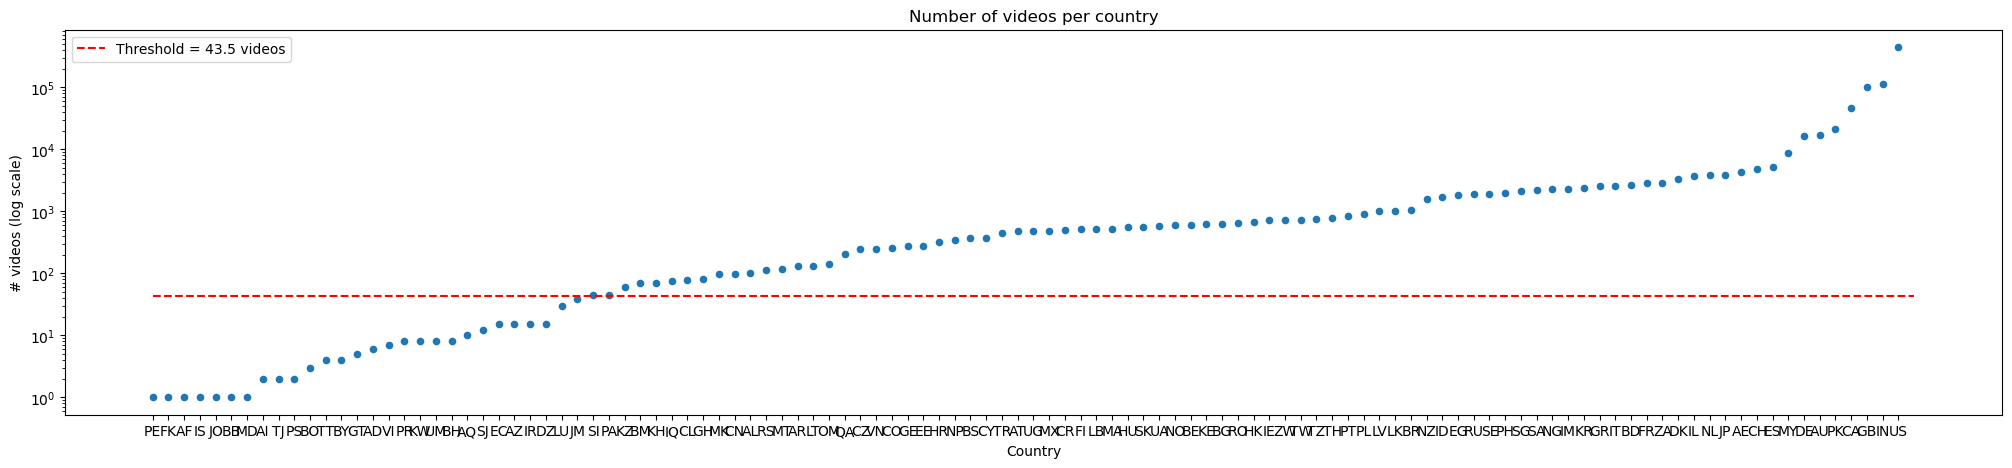

In [14]:
numericals = pd.read_csv(op.join(path_deriv, 'country_numericals.csv'), index_col=0)
quantile_threshold = numericals['# videos'].quantile(0.25)

fig, ax = plt.subplots(1, 1, figsize=(25,5))
numericals.sort_values(by = '# videos').plot(kind='scatter', y='# videos', x='country', logy=True, figsize=(25,5), title='Number of videos per country', ax=ax)
ax.plot([0, len(numericals)], [quantile_threshold, quantile_threshold], 'r--', label=f'Threshold = {quantile_threshold} videos')
ax.set_xlabel('Country')
ax.set_ylabel('# videos (log scale)')
plt.legend()
# filter at 25% quantile
numericals = numericals[numericals['# videos'] > quantile_threshold]

In [158]:
from country_analysis import get_region, custom_color_map
numericals['like_per_view_per_video'] = numericals['like_per_view'] / numericals['# videos']
numericals['dislike_per_view_per_video'] = numericals['dislike_per_view'] / numericals['# videos']
numericals['like_per_vid'] = numericals['like_count'] / numericals['# videos']
numericals['dislike_per_vid'] = numericals['dislike_count'] / numericals['# videos']
numericals['country_name'] = numericals.country.apply(get_country_fullname)
numericals['Region'] = numericals.country_name.apply(get_region)
numericals.Region = numericals.Region.apply(lambda x: 'Oceania' if x == 'Australia and New Zealand' else x)

In [169]:
numericals['color'] = numericals['region'].map(custom_color_map)

fig = px.scatter(numericals, x="like_per_vid", y="dislike_per_vid",
	         size="view_count", color="Region",
                 hover_name="country_name", 
                 color_discrete_map = custom_color_map,
                 log_x = False, log_y=False, 
                 custom_data=['country_name', '# videos'],
                 size_max=50,
                 text="country",
    )

fig.update_layout(
    xaxis=dict(title="Likes per video",tickformat=".1s"),
    yaxis=dict(title="Dislikes per video",tickformat=".1s"),
    #plot_bgcolor="lightgray", 
    paper_bgcolor="white", 
    showlegend=True ,
    legend=dict(font=dict(size=11)),
)
fig.update_traces( # change text inside bubbles
    textfont=dict(size=12, color='white'),
    textposition='middle center',
    hovertemplate="<b>%{customdata[0]}</b><br> Likes per video: %{x:.0f} <br> Dislikes per video: %{y:.0f}<br> Median Views: %{marker.size:.0f} <br> # videos: %{customdata[1]:,.0f}",
    hoverlabel=dict(font=dict(size=12)),
    
)

lines = [
    {"slope": 0.5, "intercept": 0, "name": "1/2"},
    {"slope": 0.33, "intercept": 0, "name": "1/3"}
]

# Add lines to the plot
for line in lines:
    x_vals = np.array([0, 10])  # Define the x-range for the line
    y_vals = line["slope"] * x_vals + line["intercept"]  # Calculate y = mx + b
    fig.add_trace(
        go.Scatter(
            x=x_vals, 
            y=y_vals, 
            mode="lines", 
            name=line["name"], 
            line=dict(dash="dash")  # Optional: make the lines dashed
        )
    )
    
# fig.write_html(op.join(path_country_fig,'country_likes_dislikes.html'), auto_open=True)
fig.show()

In [155]:
# We wanted to check if this was more intuitive but it's not
fig = px.scatter(numericals, x="like_per_view_per_video", y="dislike_per_view_per_video",
	         size="view_count", color="country",
                 hover_name="country_name", 
                 log_x = False,log_y=False, 
                 custom_data='country_name',
                 size_max=50,
                 text="country",
    )

fig.update_layout(
    xaxis=dict(title="Like Count (log scale)",tickformat=".1s"),
    yaxis=dict(title="Dislike Count",tickformat=".1s"),
    paper_bgcolor="white",    
    showlegend=True 
)
fig.update_traces( # change text inside bubbles
    textfont=dict(size=12, color='white'),
    textposition='middle center',
    hovertemplate="<b>%{customdata}</b><br> Likes per video: %{x:.0f} <br> Dislikes per video: %{y:.0f}<br> Median Views: %{marker.size:.0f}",
)

#fig.write_html(op.join(path_country_fig,'country_likes_dislikes.html'), auto_open=True)
fig.show()

In [174]:
# compute like dislike ratio
numericals['dislike_like_ratio'] = numericals['dislike_count'] / numericals['like_count']
numericals.sort_values(by='dislike_like_ratio', ascending=True)[['country_name', 'dislike_like_ratio']]

,country_name,dislike_like_ratio
40,Falkland Islands (Malvinas),0.004189
4,Albania,0.022692
43,Georgia,0.024048
44,Ghana,0.025130
34,Algeria,0.026174
...,...,...
52,Israel,0.265397
70,Luxembourg,0.294357
95,Serbia,0.357258
120,Viet Nam,0.378424


In [177]:
numericals[numericals.country.isin(['AT', 'JP', 'TW', 'RO', 'RS', 'LU', 'VN','KR'])][['country_name',  'dislike_like_ratio']].sort_values(by='dislike_like_ratio', ascending=False)

,country_name,dislike_like_ratio
120,Viet Nam,0.378424
95,Serbia,0.357258
70,Luxembourg,0.294357
64,"Korea, Republic of",0.260530
61,Japan,0.083739
111,"Taiwan, Province of China",0.041106
8,Austria,0.035502
94,Romania,0.031121


# TOOLS

In [30]:
pd.set_option("display.max_rows", 11)